In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')

    file_name = 'Task_4.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")

    print(path_to_file)

    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
./gdrive/MyDrive/URABNA2/
/content/gdrive/MyDrive/URABNA2


In [ ]:
pip install osmnx==0.16.2

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [4]:
import numpy as np
import pandas as pd
import osmnx as ox
from shapely.geometry import Polygon
from shapely.geometry import shape
import json
import os
import time
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from collections import defaultdict
%matplotlib inline

pd.set_option('display.max_columns', None)

In [5]:
def getMinMax(xMax, yMax, xMin, yMin, bFirst, xLong, yLat):
    # return the min, max of x, y coord
    
    if bFirst:
        xMin = xMax = xLong
        yMin = yMax = yLat
        bFirst      = False
    else:
        if xLong > xMin:
            xMin = xLong
        elif xLong < xMax:
            xMax = xLong

        if yLat < yMin:
            yMin = yLat
        elif yLat > yMax:
            yMax = yLat
                    
    return xMax, yMax, xMin, yMin, bFirst

# Task 4

Task 4: - Plot trajectory route onto road network

In [6]:
# import results trajectory dataset
dfMapped = pd.read_csv('./data/matchedMaps.csv')
dfMapped = pd.DataFrame(dfMapped)

In [7]:
mapList    = []
count       = 0
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True

for item in dfMapped['mgeom']:
    item = item[11: -1] # remove 1st 2 & last 2 brackets
    map = []
    
    if len(item) <= 2: # []
        print('Skip empty row:', count, ', len:', len(item), ', element:', item)
    else:
        for elem in item.split(','):
            xLong, yLat = elem.split()
            map.append((float(xLong), float(yLat))) # tuple of x, y coords
            
            xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, xLong, yLat)
        
        
        mapList.append(map)

    count += 1
    
print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

Skip empty row: 2 , len: 0 , element: 
Skip empty row: 3 , len: 0 , element: 
Skip empty row: 9 , len: 0 , element: 
Skip empty row: 15 , len: 0 , element: 
Skip empty row: 31 , len: 0 , element: 
Skip empty row: 33 , len: 0 , element: 
Skip empty row: 39 , len: 0 , element: 
Skip empty row: 57 , len: 0 , element: 
Skip empty row: 59 , len: 0 , element: 
Skip empty row: 64 , len: 0 , element: 
Skip empty row: 86 , len: 0 , element: 
Skip empty row: 101 , len: 0 , element: 
Skip empty row: 127 , len: 0 , element: 
Skip empty row: 132 , len: 0 , element: 
Skip empty row: 138 , len: 0 , element: 
Skip empty row: 184 , len: 0 , element: 
Skip empty row: 212 , len: 0 , element: 
Skip empty row: 216 , len: 0 , element: 
Skip empty row: 224 , len: 0 , element: 
Skip empty row: 230 , len: 0 , element: 
Skip empty row: 265 , len: 0 , element: 
Skip empty row: 294 , len: 0 , element: 
Skip empty row: 302 , len: 0 , element: 
Skip empty row: 303 , len: 0 , element: 
Skip empty row: 309 , len: 0 ,

In [8]:
# extract 10 trajectory from the list of 1000
limit         = 10
mapListLen   = len(dfMapped)
mapCoords        = []
xMax = yMax = 0
xMin = yMin = 0
bFirst      = True
#print('len:', trajListLen)

for i in range(limit):
    tmpMap = mapList[i]
    x = []
    y = []
    
    if len(tmpMap) <= 2: # []
        print('Skip empty row:', i, ', len:', len(tmpMap), ', traj:', tmpMap)
    else:
        for tmpCord in tmpMap:
            tmpX = tmpCord[0]
            tmpY = tmpCord[1]
            #print('x:', tmpX, ', y:', tmpY)
            x.append(tmpX)
            y.append(tmpY)
            
            xMax, yMax, xMin, yMin, bFirst = getMinMax(xMax, yMax, xMin, yMin, bFirst, tmpX, tmpY)
            
    mapCoords.append((x, y))
    #print('x:', x)
    #print('y:', y)
    
print('xMin:', xMin, ', yMin:', yMin, ', xMax:', xMax, ', yMax:', yMax)

xMin: -8.5621277 , yMin: 41.139909 , xMax: -8.6891266 , yMax: 41.180528


/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


   Duration 3.451671838760376 seconds


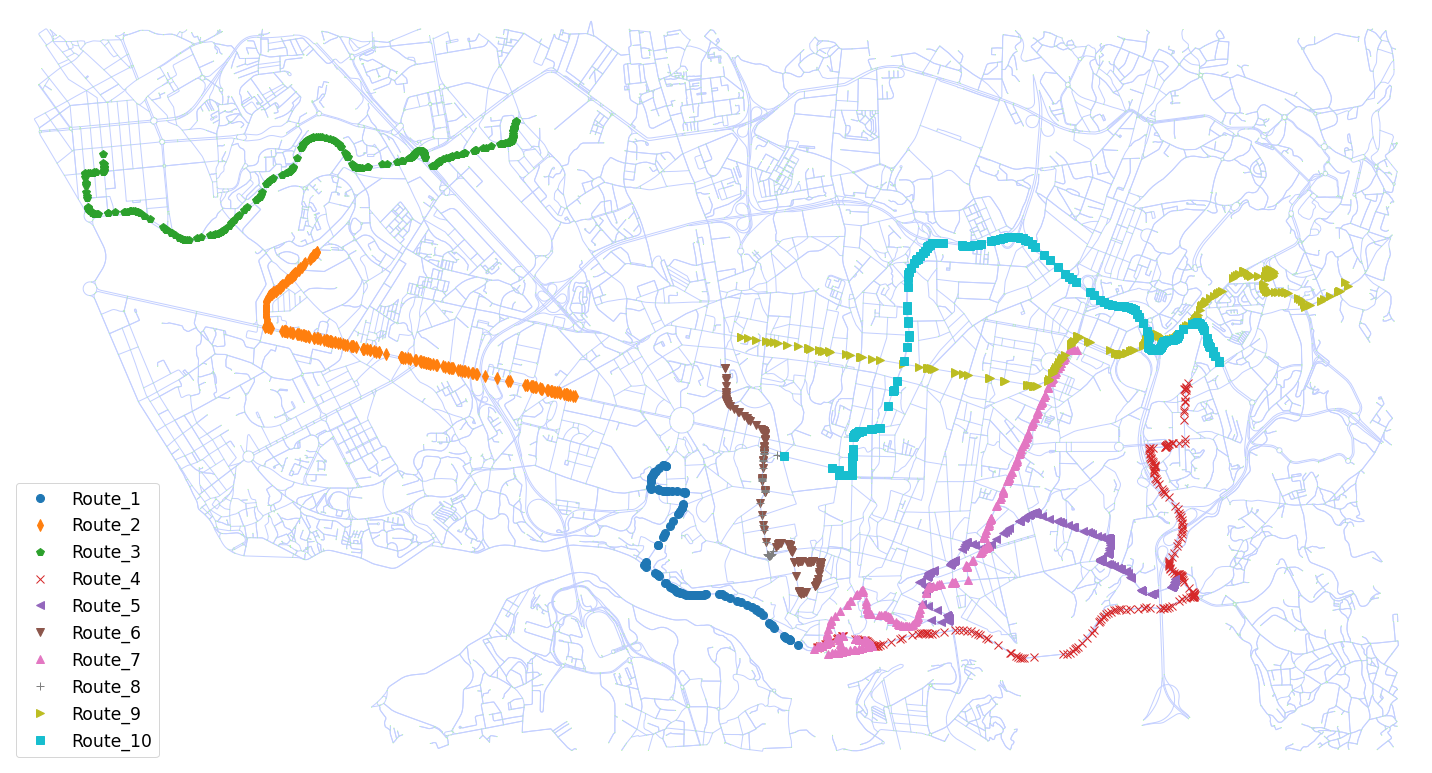

In [9]:
# sub graph using bounding box method
startTime       = time.time()
delta           = 0.01
bounds          = (xMax - delta / 2, xMin + delta / 2, yMin - delta * 0.7, yMax + delta * 0.7)
x1, x2, y1, y2  = bounds
boundaryPolygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)])
G3              = ox.graph_from_polygon(boundaryPolygon, network_type = 'drive')

# plot all pts
startTime = time.time()
#marker    = ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's']
marker    = ['o', 'd', 'p', 'x', '<', 'v', '^', '+', '>', 's']
fig, ax   = ox.plot_graph(G3, figsize = (20, 20), bgcolor = '#FFFFFF', \
                          node_color = '#ACFF97', node_size = 1, \
                          edge_color = '#C4D0FF', show = False, close = False)

for i in range(len(mapCoords)):
    ax.plot(mapCoords[i][0], mapCoords[i][1], marker[i], ms = 8, label = 'Route_{}'.format(i + 1))

plt.legend(fontsize = 'xx-large')
plt.tight_layout()
# plt.savefig('./5mostoften.png', dpi = 320)
print("   Duration %s seconds" % (time.time() - startTime))